## Import libraries

In [1]:
#importing required modules

import gdown
import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms

import os
import torch.optim as optim
from PIL import ImageFile

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve


#checking the availability of a GPU
use_cuda = torch.cuda.is_available()

## Dataset

In [2]:
#invstigating number of files
data = '/content/drive/MyDrive/ELTE/DND/A1/Data/subset'

print('There are %d total food images.' % len(np.array(glob(data + "/*/*"))))

There are 5000 total food images.


#### Loading one example for each object type from the dataset


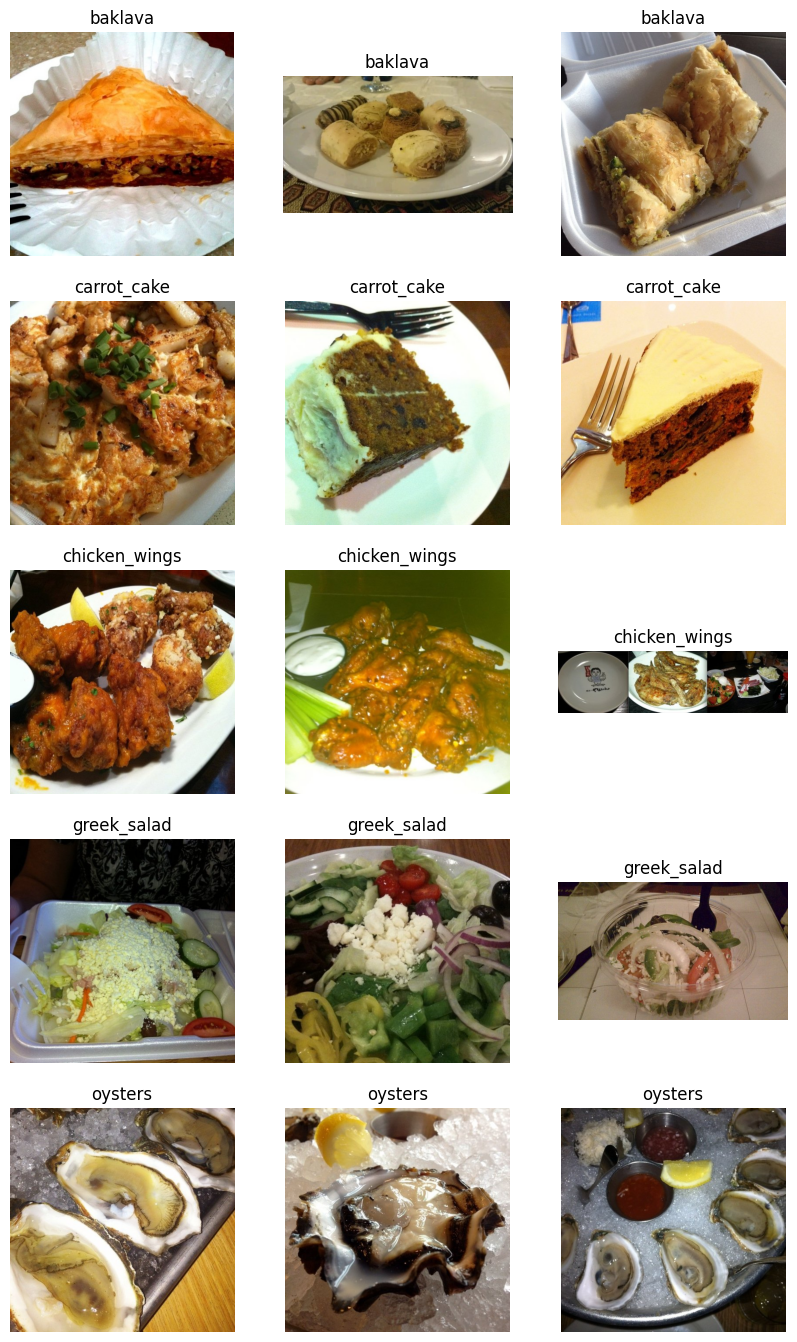

In [3]:
classes = list(file.split('/')[-1] for file in glob(data + '/*'))

fig, ax = plt.subplots(len(classes), len(classes)-2,  figsize=(13, 10))
plt.subplots_adjust(top = 1.3, bottom = 0, right = 1.1, left = 0.5)

for i, folder in enumerate(glob(data + '/*')):
  for j, file in enumerate(glob(folder + '/*')):
    if j > (len(classes) - 3): break
    image = plt.imread(file)
    ax[i, j].imshow(image)
    ax[i,j].axis('off')
    #plt.tight_layout(pad = 0.5)
    ax[i,j].set_title(classes[i])

plt.show()



#### Splitting the dataset

In [4]:
# Loading the dataset
orig_set = datasets.ImageFolder(data, transform = transforms.ToTensor())  # dataset

# Splitting Data into test, train and validation

train_data, temp_data = torch.utils.data.random_split(orig_set, [0.8, 0.2])
test_data, val_data = torch.utils.data.random_split(temp_data, [0.5, 0.5])

<BarContainer object of 3 artists>

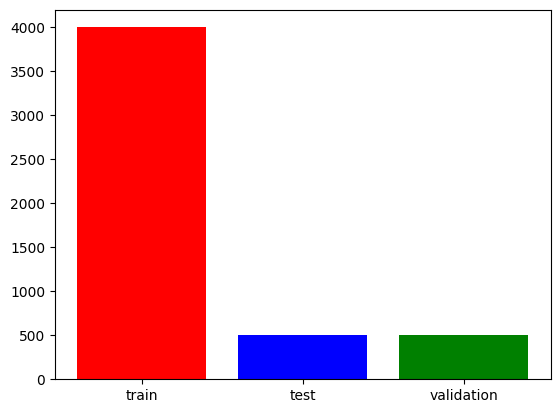

In [5]:
plt.bar(['train', 'test', 'validation'], [len(train_data), len(test_data), len(val_data)], color = ['red', 'blue', 'green'])

In [6]:
# Extracting the list of classes/labels from the data
class_names = orig_set.classes
print(class_names)

['baklava', 'carrot_cake', 'chicken_wings', 'greek_salad', 'oysters']


#### Pre-processing the dataset (data loader with transformations)

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


IMG_SIZE = 224  # Size of images used for training
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_SDEV = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=(5, 50), translate=(0.1, 0.3), scale=(0.9, 1.1)),
        transforms.RandomPerspective(distortion_scale=0.2),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.Normalize(IMG_MEAN, IMG_SDEV)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256, antialias=True),
        transforms.CenterCrop(IMG_SIZE),
        transforms.Normalize(IMG_MEAN, IMG_SDEV)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256, antialias=True),
        transforms.CenterCrop(IMG_SIZE),
        transforms.Normalize(IMG_MEAN, IMG_SDEV)
    ]),
}

train = MyDataset(train_data, transform=data_transforms['train'])
valid = MyDataset(val_data, transform=data_transforms['val'])
test = MyDataset(test_data, transform=data_transforms['test'])

In [8]:
# defining batch size
batch_size = 64

# Creating loaders for the dataset
loaders_transfer={
    'train': torch.utils.data.DataLoader(train, batch_size, shuffle=True, num_workers=2),
    'valid': torch.utils.data.DataLoader(valid, batch_size, shuffle=True, num_workers=2),
    'test': torch.utils.data.DataLoader(test, batch_size, shuffle=True, num_workers=2)
}

#### Check the number of images and class balances in the  train, validation and test set

In [9]:
# Extracting class distribution in the data

train_class, test_class, val_class = [], [], []

for i, (_, label) in enumerate(test_data):
  if (i % 50)==0: print(i, end = ' ')
  test_class.append(classes[label])

print('')
for i, (_, label) in enumerate(val_data):
  if (i % 50)==0: print(i, end = ' ')
  val_class.append(classes[label])

print('')
for i, (_, label) in enumerate(train_data):
  if (i % 50)==0: print(i, end = ' ')
  train_class.append(classes[label])

0 50 100 150 200 250 300 350 400 450 
0 50 100 150 200 250 300 350 400 450 
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000 2050 2100 2150 2200 2250 2300 2350 2400 2450 2500 2550 2600 2650 2700 2750 2800 2850 2900 2950 3000 3050 3100 3150 3200 3250 3300 3350 3400 3450 3500 3550 3600 3650 3700 3750 3800 3850 3900 3950 

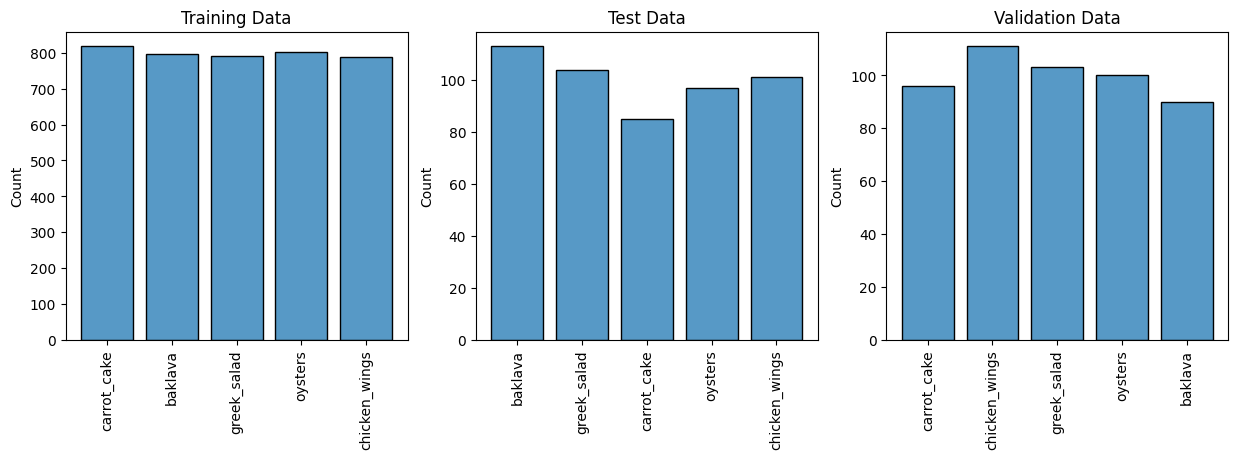

In [10]:
# Plotting the Class distributions

plt.figure(figsize = (15,4))

plt.subplot(131)
sns.histplot(train_class, shrink=0.8, discrete = True)
plt.xticks(rotation=90)
plt.title('Training Data')

plt.subplot(132)
sns.histplot(test_class, shrink=0.8, discrete = True)
plt.xticks(rotation=90)
plt.title('Test Data')

plt.subplot(133)
sns.histplot(val_class, shrink=0.8, discrete = True)
plt.xticks(rotation=90)
plt.title('Validation Data')
plt.show()

## Convolutional Neural Network Architecture

#### Implement the original architecture

In [25]:
model_base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
if use_cuda:
  model_base = model_base.cuda()

#### Summary of the original architecture

In [27]:
summary(model_base, (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#### Implement the new architecture with less parameter

In [29]:
# Importing the pretrained model
model_2 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze weights
# for param in model_2.parameters():
#     param.requires_grad = False

n_inputs = model_2.fc.in_features

# Replacing the top dense layers with self defined trainable layers
model_2.fc = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.LeakyReLU(inplace = True),

    nn.Linear(512,256),
    nn.LeakyReLU(inplace=True),

    nn.Linear(256,64),
    nn.LeakyReLU(inplace=True),

    nn.Linear(64,16),
    nn.LeakyReLU(inplace=True),

    nn.Linear(16,5),
    nn.Sigmoid()
)


# Modifying the backbone layers

model_2.layer1 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=(3, 3), bias=False).requires_grad_(),
    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.LeakyReLU(inplace=True)
    )
model_2.layer2 = nn.Sequential(
    nn.Conv2d(64, 128, kernel_size=(3, 3), bias=False).requires_grad_(),
    nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.LeakyReLU(inplace=True)
    )


#transferring the model to GPU
if use_cuda:
  model_2 = model_2.cuda()

#### Summary of the new architecture

In [30]:
summary(model_2, (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 54, 54]          36,864
       BatchNorm2d-6           [-1, 64, 54, 54]             128
         LeakyReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8          [-1, 128, 52, 52]          73,728
       BatchNorm2d-9          [-1, 128, 52, 52]             256
        LeakyReLU-10          [-1, 128, 52, 52]               0
           Conv2d-11          [-1, 256, 26, 26]         294,912
      BatchNorm2d-12          [-1, 256, 26, 26]             512
             ReLU-13          [-1, 256, 26, 26]               0
           Conv2d-14          [-1, 256,

## Training

#### Define loss function

In [31]:
# selecting loss function
criterion_transfer = nn.CrossEntropyLoss()

#### Define optimizer

In [32]:
#using Adam optimizer
optimizer_2 = optim.Adam(model_2.fc.parameters(), lr=0.0005)

#### Train network

In [35]:

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Creating the function for training
def training(n_epochs, loaders, model, optimizer, criterion, use_cuda):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    trainingloss = []
    validationloss = []
    trainingacc = []
    validationacc = []

    for epoch in range(1, n_epochs+1):
        print(f"-----------------Epoch: {epoch}/{n_epochs}------------------")
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct1 = 0.
        total1 = 0.
        correct2 = 0.
        total2 = 0.

        ###################
        # training the model #
        ###################
        model.train()
        print("Train: ")
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            print(f"{batch_idx+1}/{len(loaders['train'])}", end = "-")

            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct1 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total1 += data.size(0)


        ######################
        # validating the model #
        ######################
        model.eval()
        print('\nValidation')
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            print(f"{batch_idx+1}/{len(loaders['valid'])}", end = "-")

            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct2 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total2 += data.size(0)



        train_loss = train_loss/len(train)
        valid_loss = valid_loss/len(valid)

        trainingloss.append(train_loss)
        validationloss.append(valid_loss)

        acc1 = 100. * correct1 / total1
        acc2 =  100. * correct2 / total2

        trainingacc.append(acc1)
        validationacc.append(acc2)
        # printing training/validation statistics
        print('\nTraining Loss: {:.6f} \nTraining Accuracy: {:.4f} \nValidation Loss: {:.6f} \nValidation Accuracy: {:.4f}'.format(
            train_loss,
            acc1,
            valid_loss,
            acc2
            ))

        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            # torch.save(model.state_dict(), save_path)
            model1 = model

            print('Validation loss decreased ({:.6f} --> {:.6f}).'.format(
            valid_loss_min,
            valid_loss))

            valid_loss_min = valid_loss

    # return trained model
    return model1, trainingloss, validationloss, trainingacc, validationacc

In [37]:
# training the modified model, with the new backbone layers
n_epochs = 50

model2, train_loss2, valid_loss2, train_acc2, valid_acc2 = training(n_epochs, loaders_transfer, model_2, optimizer_2, criterion_transfer, use_cuda)

-----------------Epoch: 1/50------------------
Train: 
1/63-2/63-3/63-4/63-5/63-6/63-7/63-8/63-9/63-10/63-11/63-12/63-13/63-14/63-15/63-16/63-17/63-18/63-19/63-20/63-21/63-22/63-23/63-24/63-25/63-26/63-27/63-28/63-29/63-30/63-31/63-32/63-33/63-34/63-35/63-36/63-37/63-38/63-39/63-40/63-41/63-42/63-43/63-44/63-45/63-46/63-47/63-48/63-49/63-50/63-51/63-52/63-53/63-54/63-55/63-56/63-57/63-58/63-59/63-60/63-61/63-62/63-63/63-
Validation
1/8-2/8-3/8-4/8-5/8-6/8-7/8-8/8-
Training Loss: 0.000393 
Training Accuracy: 23.9250 
Validation Loss: 0.002993 
Validation Accuracy: 41.0000
Validation loss decreased (inf --> 0.002993).
-----------------Epoch: 2/50------------------
Train: 
1/63-2/63-3/63-4/63-5/63-6/63-7/63-8/63-9/63-10/63-11/63-12/63-13/63-14/63-15/63-16/63-17/63-18/63-19/63-20/63-21/63-22/63-23/63-24/63-25/63-26/63-27/63-28/63-29/63-30/63-31/63-32/63-33/63-34/63-35/63-36/63-37/63-38/63-39/63-40/63-41/63-42/63-43/63-44/63-45/63-46/63-47/63-48/63-49/63-50/63-51/63-52/63-53/63-54/63-55/63-

#### Loss on training and validation sets

Text(0, 0.5, 'loss')

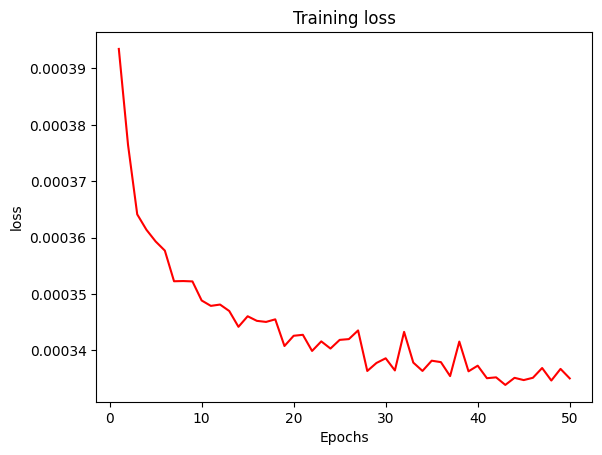

In [56]:
#converting the tensor object to a list for post processing/graphs

trainL, validL = [],[]

for i in train_loss2:
  trainL.append(i.cpu().numpy())
for i in valid_loss2:
  validL.append(i.cpu().numpy())

#Plotting the training loss

plt.plot(range(1, n_epochs+1),trainL, color='r')
plt.title("Training loss")
plt.xlabel('Epochs')
plt.ylabel("loss")

Text(0, 0.5, 'loss')

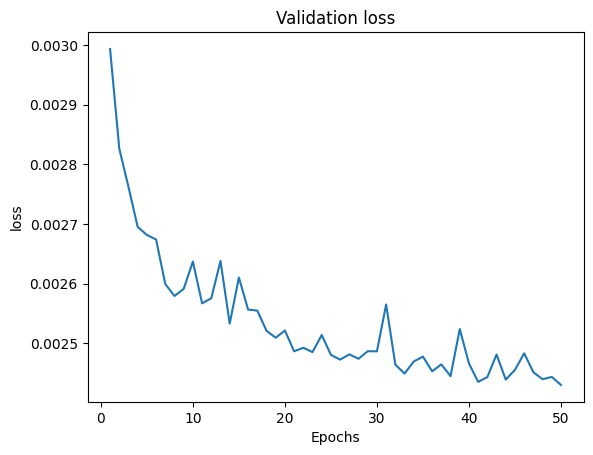

In [57]:
plt.plot(range(1, n_epochs+1),validL)
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel("loss")

#### Accuracy on training and validation sets

Text(0, 0.5, 'loss')

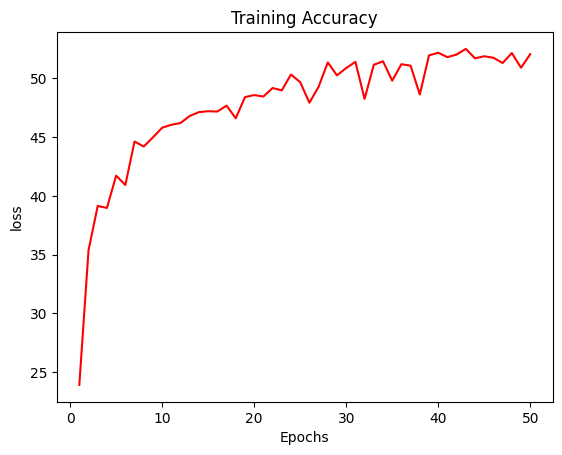

In [58]:
#Plotting the training acc

plt.plot(range(1, n_epochs+1),train_acc2, color='r')
plt.title("Training Accuracy")
plt.xlabel('Epochs')
plt.ylabel("loss")

Text(0, 0.5, 'loss')

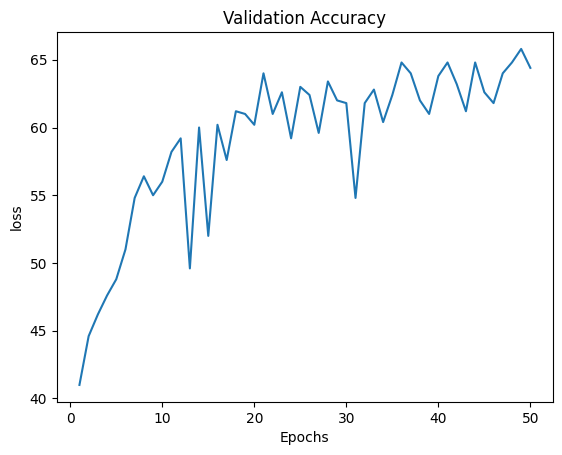

In [59]:
plt.plot(range(1, n_epochs+1),valid_acc2)
plt.title("Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel("loss")

#### Save trained CNN

In [62]:
torch.save(model2.state_dict(), '/content/drive/MyDrive/ELTE/DND/A1/model_new.pt')

## Evaluation and Testing

In [63]:
model_2.load_state_dict(torch.load('/content/drive/MyDrive/ELTE/DND/A1/model_new.pt'))

<All keys matched successfully>

In [64]:
def test(loaders, model, criterion, use_cuda):

    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []
    testacc = 0

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # moving to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        print(f"{batch_idx+1}/{len(loaders['test'])}", end = "-")
        # forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # updating average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # converting the output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        preds.append(pred)
        targets.append(target)
        # compare predictions
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    testacc = 100. * correct / total
    # print('Test Loss: {:.7f}\n'.format(test_loss))

    # print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    #     100. * correct / total, correct, total))

    return preds, targets, testacc

# calling test function
preds, targets, testacc = test(loaders_transfer, model2, criterion_transfer, use_cuda)

1/8-2/8-3/8-4/8-5/8-6/8-7/8-8/8-

In [70]:
# Testing the base model/original architecture
preds_b, targets_b, testacc_b = test(loaders_transfer, model_base, criterion_transfer, use_cuda)

1/8-2/8-3/8-4/8-5/8-6/8-7/8-8/8-

In [71]:
print(f"Training Accuracy: {np.max(train_acc2)}\nValidation Accuracy: {np.max(valid_acc2)}\nTest Accuracy: {testacc}")

Training Accuracy: 52.5
Validation Accuracy: 65.8
Test Accuracy: 62.2


In [72]:
#converting the tensor object to a list for metric functions

preds2, targets2 = [],[]

for i in preds:
  for j in range(len(i)):
    preds2.append(i.cpu().numpy()[j])
for i in targets:
  for j in range(len(i)):
    targets2.append(i.cpu().numpy()[j])


preds_b2, targets_b2 = [],[]

for i in preds_b:
  for j in range(len(i)):
    preds_b2.append(i.cpu().numpy()[j])
for i in targets_b:
  for j in range(len(i)):
    targets_b2.append(i.cpu().numpy()[j])

#### Confusion matrix

Accuracy of base model: 0.0




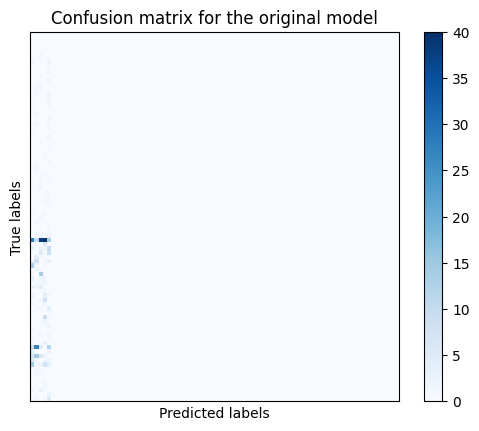

In [77]:
#plotting the confusion matrix for testing data for the original model

print(f"Accuracy of base model: {accuracy_score(preds_b2, targets_b2)}\n\n")
cm = confusion_matrix(preds_b2, targets_b2)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix for the original model')
plt.colorbar()
plt.show()

Accuracy of modified model: 62.2 %

Confusion Matrix:
 [[71 14 16  3  5]
 [16 52 21  8  3]
 [10 11 54 10  8]
 [ 8  6  4 78 25]
 [ 8  2  6  5 56]]


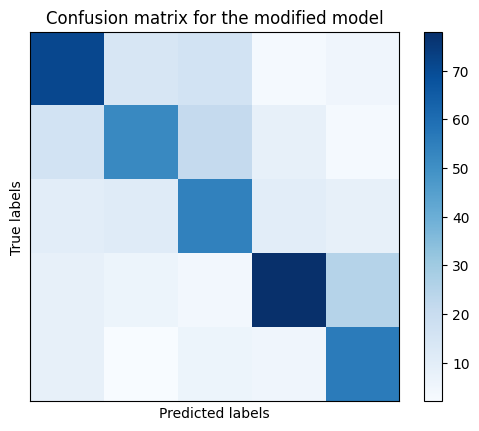

In [80]:
#plotting the confusion matrix for testing data for the modified model
print(f"Accuracy of modified model: {testacc} %\n")

cm = confusion_matrix(preds2, targets2)
print('Confusion Matrix:\n', cm)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix for the modified model')
plt.colorbar()
plt.show()

In [81]:
def visualize_model(model, correct, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 1

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loaders_transfer['test']):
            if use_cuda:
              inputs = inputs.cuda()
              labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
              if correct:
                if class_names[preds[j]] == class_names[labels.cpu().data[j]]:
                  fig = plt.figure(figsize=(10,10))
                  images_so_far += 1
                  ax = plt.subplot(2, num_images//2, images_so_far)
                  ax.axis('off')
                  ax.set_title(f"predicted: {class_names[preds[j]]}\nActual: {class_names[labels.cpu().data[j]]}")
                  plt.imshow(np.rollaxis(inputs.cpu().data[j].numpy(), 0, 3))

                  if images_so_far == num_images:
                      model.train(mode=was_training)
                      return
              else:
                  if class_names[preds[j]] != class_names[labels.cpu().data[j]]:
                    fig = plt.figure(figsize=(10,10))
                    images_so_far += 1
                    ax = plt.subplot(2, num_images//2, images_so_far)
                    ax.axis('off')
                    ax.set_title(f"predicted: {class_names[preds[j]]}\nActual: {class_names[labels.cpu().data[j]]}")
                    plt.imshow(np.rollaxis(inputs.cpu().data[j].numpy(), 0, 3))

                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return

        model.train(mode=was_training)

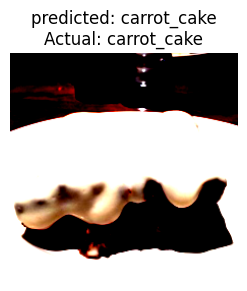

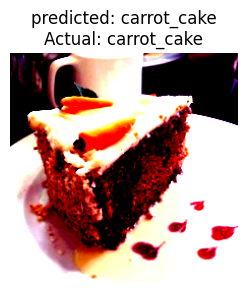

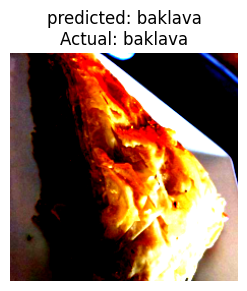

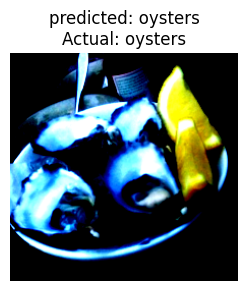

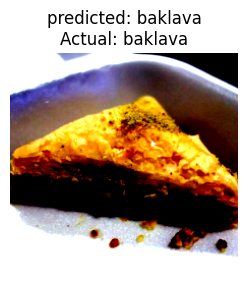

In [83]:
visualize_model(model_2, correct=True)

#### Missed predictions

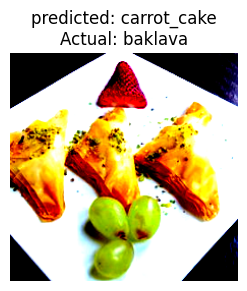

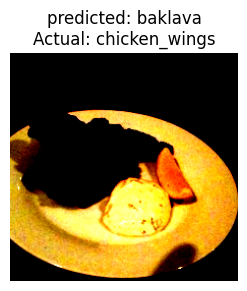

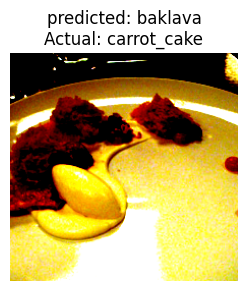

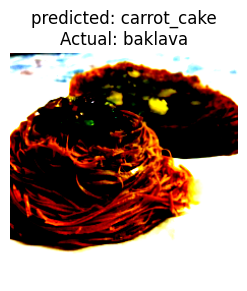

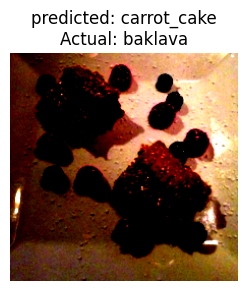

In [84]:
visualize_model(model_2, correct=False)